In [ ]:
from pathlib import Path

import pandas as pd



import torch
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torch


import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from pathlib import Path

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split

import torch

from torchvision.models import resnet18, ResNet18_Weights


import torch
import torch.nn as nn
import torch.nn.functional as F

from tensorflow.keras.preprocessing.text import Tokenizer

In [361]:

metadata_path = Path("../data/augmented/metadata.csv")
augmented_dir = Path("../data/augmented")
df = pd.read_csv(metadata_path)
print(df.columns)
print(df.iloc[1])




Index(['image_path', 'label', 'caption'], dtype='object')
image_path                                water_070_spatial.jpg
label                                               Label.WATER
caption       A kayaker wearing a blue wetsuit and black hel...
Name: 1, dtype: object


In [362]:
def get_label(filename: str):
    return filename.split("_")[0]

def get_uuid(filename: str):
    name = Path(filename).stem
    parts = name.split("_")
    return "_".join(parts[:2])

def build_augmented_path(img_path: Path, base_dir: Path):
    img_path = Path(img_path)
    filename = img_path.name
    label = get_label(filename)
    uuid = get_uuid(filename)

    return base_dir / label / uuid / filename

get_label(df['image_path'].iloc[1])
get_uuid(df["image_path"].iloc[1])




'water_070'

In [363]:
captions = df["caption"].drop_duplicates().reset_index(drop=True)
print(f"Avant : {len(df)}")
print(f"Avant : {len(captions)}")

Avant : 1800
Avant : 600


TOKENIZER


In [364]:
vocab_size = 1000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(captions)
actual_vocab_size = len(tokenizer.word_index) + 1
print(f"Taille du vocabulaire : {len(tokenizer.word_index)}")
print(f"Vocab size:  {actual_vocab_size}")

Taille du vocabulaire : 973
Vocab size:  974


In [365]:
captions_to_sequences = tokenizer.texts_to_sequences(df["caption"])
print(df["caption"].iloc[1])
print(captions_to_sequences[1])

A kayaker wearing a blue wetsuit and black helmet paddles his yellow kayak in murky rolling rapids .
[2, 166, 30, 2, 25, 200, 6, 10, 75, 456, 18, 48, 316, 3, 317, 457, 458]


In [366]:
oov_id = tokenizer.word_index["<OOV>"]
count = 0
for i in  range(len(captions_to_sequences)):
    count += captions_to_sequences[i].count(oov_id)

print(count)

0


In [367]:
max_seq_len = max(len(seq) for seq in captions_to_sequences)
print(max_seq_len)

33


TRANSFORMS

In [368]:
transforms_resnet = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

DATASET


In [369]:
class CLIPDataset(Dataset):
    def __init__(self, df, base_dir: Path
    , transform, tokenizer, max_seq_len:int):
        self.base_dir = base_dir
        

        self.img_paths = df["image_path"].tolist()
        self.labels = df["label"].tolist()
        self.captions = df["caption"].tolist()

        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_seq_len
        
        self.classes = sorted(set(self.labels))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

    def __getitem__(self, idx):

        # Load image
        img_path = Path(build_augmented_path(self.img_paths[idx], self.base_dir))
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        caption = self.captions[idx]

        seq = self.tokenizer.texts_to_sequences([caption])  
        padded = pad_sequences(
            seq,
            maxlen=self.max_length,
            padding="post",
            truncating="post"
        )

        padded = torch.tensor(padded[0], dtype=torch.long)   # (max_seq_len,)

        # Label mapping
        label = torch.tensor(self.class_to_idx[self.labels[idx]])
        return {
            "caption": caption, 
            "index": idx,
            "image": img,
            "input_ids": padded,
            "label": label
        }

    def __len__(self):
        return len(self.img_paths)


In [370]:
# df["caption_to_seq"] = tokenizer.texts_to_sequences(df["caption"].tolist())

# padded = pad_sequences(
#     df["caption_to_seq"],
#     maxlen=max_seq_len,
#     padding='post',
#     truncating='post'
# )

# df["seq_padded"] = list(padded)

# print(df["caption"].iloc[1])
# print(df["caption_to_seq"].iloc[1])
# print(df["seq_padded"].iloc[1])


In [371]:
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=11)
df_test, df_val = train_test_split(df_temp, test_size=0.15, random_state=11)


In [372]:
print(df_train["label"].value_counts(normalize=True) * 100)
print(df_test["label"].value_counts(normalize=True) * 100)
print(df_val["label"].value_counts(normalize=True) * 100)

label
Label.BALL     25.873016
Label.BIKE     25.476190
Label.WATER    24.682540
Label.DOG      23.968254
Name: proportion, dtype: float64
label
Label.DOG      26.579521
Label.WATER    26.143791
Label.BIKE     24.400871
Label.BALL     22.875817
Name: proportion, dtype: float64
label
Label.DOG      32.098765
Label.WATER    23.456790
Label.BALL     23.456790
Label.BIKE     20.987654
Name: proportion, dtype: float64


In [373]:
train_dataset = CLIPDataset(df_train, augmented_dir, transforms_resnet, tokenizer,max_seq_len)
test_dataset = CLIPDataset(df_test, augmented_dir, transforms_resnet, tokenizer, max_seq_len)
val_dataset = CLIPDataset(df_val, augmented_dir,  transforms_resnet, tokenizer, max_seq_len)

In [374]:
print(len(val_dataset))

81


In [375]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, drop_last=True)

In [376]:
for batch in val_loader:
    print(batch)

{'caption': ['A couple ride bikes next to an orange fence by the ocean .', 'A man on a bicycle jumping off a dirt ramp with one foot on the ground', 'A cyclist wearing a red helmet is riding on the pavement .', 'A puppy plays with an adult dog in the snow .', 'A motocross rider is on a dirt hill .', 'A man showering in a home outdoor shower facility .', 'A male and a female are leaning against railing looking off with the ocean in the background', 'A black and white dog jumping into a pool .', 'A black puppy is biting a tree limb .', 'A group of dogs run down a dry field .', 'a brown dog running down a paved pathway', 'A black dog is running in the grass .', 'A man in a baseball hat and sunglasses watching an event in a crowd .', 'A dog is running along a beach on a sunny day .', 'A group of cyclists race uphill on foot with their bikes on their shoulders .', 'A brown dog and two white dogs are bounding after a ball .'], 'index': tensor([23,  6, 13, 63, 33, 26, 22,  0, 37, 54, 32, 21, 

In [377]:
import torchvision.models as models


class VisionEncoder(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()
        base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        self.backbone = nn.Sequential(
                     base_model.conv1, base_model.bn1, base_model.relu, base_model.maxpool, 
                     base_model.layer1, base_model.layer2, base_model.layer3, base_model.layer4, base_model.avgpool,
                 )
        
        # Projection linéaire vers l'espace d'embedding
        self.proj = nn.Linear(base_model.fc.in_features, embed_dim)


    def forward(self, x):
        x = self.backbone(x)         # → [B, 512, 1, 1]
        x = x.flatten(1)             # → [B, 512]
        x = self.proj(x)             # → [B, embed_dim]
        return x

    

In [378]:
class PositionalEmbedding(nn.Module):
    def __init__(self, sequence_length: int, vocab_size:int, embed_dim:int):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, embed_dim)
        self.position_embeddings = nn.Embedding(sequence_length, embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        return self.token_embeddings(x) + self.position_embeddings(positions)


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout_rate: float = 0.1) -> None:
        super().__init__()
        self.att = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate, batch_first=True)

        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )

        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor, padding_mask: torch.Tensor = None) -> torch.Tensor:
        attn_output, _ = self.att(
            x, x, x,
            key_padding_mask=padding_mask  # <-- correct masking
        )

        x = self.layernorm1(x + self.dropout1(attn_output))
        ffn_output = self.ffn(x)
        out = self.layernorm2(x + self.dropout2(ffn_output))
        return out


class SmallBERT(nn.Module):
    def __init__(self, sequence_length: int, vocab_size: int, embed_dim: int,
                 num_heads: int, ff_dim: int, num_layers: int) -> None:
        super().__init__()
        self.pos_embedding = PositionalEmbedding(sequence_length, vocab_size, embed_dim)
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim)
            for _ in range(num_layers)
        ])
        self.layernorm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (batch, seq_len) token ids
        """
        padding_mask = (x == 0)  # 0 = PAD  -> True masked in attn
        x = self.pos_embedding(x)

        for block in self.blocks:
            x = block(x, padding_mask=padding_mask)

        x = self.layernorm(x)
        return self.dropout(x)



class TextEncoder(nn.Module):
    def __init__(self, max_seq_len, vocab_size, embed_dim=128,
                 model_dim=128, num_heads=4, ff_dim=256, num_layers=2):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, model_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(max_seq_len, model_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.proj = nn.Linear(model_dim, embed_dim)

    def forward(self, input_ids):
        """
        input_ids : [B, L] (padded, PAD = 0)
        """
        B, L = input_ids.shape
        device = input_ids.device

        positions = torch.arange(0, L, device=device).unsqueeze(0)  # [1, L]

        x = self.token_emb(input_ids) + self.pos_emb(positions)     # [B, L, d]
        x = self.encoder(x)                                         # [B, L, d]

        # mask pour ignorer le padding (token = 0)
        mask = (input_ids != 0).float()                             # [B, L]
        mask = mask.unsqueeze(-1)                                   # [B, L, 1]

        x_masked = x * mask                                         # [B, L, d]
        sum_emb = x_masked.sum(dim=1)                               # [B, d]
        lengths = mask.sum(dim=1).clamp(min=1e-6)                   # [B, 1]

        mean_emb = sum_emb / lengths                                # [B, d]
        emb = self.proj(mean_emb)                                   # [B, embed_dim], pas d'activation
        return emb





In [379]:
import numpy as np

class SmallCLIP(nn.Module):
    def __init__(self, vision_encoder, text_encoder, init_temperature=0.07):
        super().__init__()
        self.vision = vision_encoder
        self.text = text_encoder

        # log(1/T), comme dans CLIP
        self.logit_scale = nn.Parameter(torch.tensor(np.log(1.0 / init_temperature)))

    def forward(self, images, input_ids):
        """
        images : [B, 3, H, W]
        input_ids : [B, L]
        """
        img_emb = self.vision(images)      # [B, D]
        txt_emb = self.text(input_ids)     # [B, D]

        # Normalisation L2
        img_emb = F.normalize(img_emb, dim=-1)
        txt_emb = F.normalize(txt_emb, dim=-1)

        # Similarité
        logits = img_emb @ txt_emb.T       # [B, B]
        logits = logits * self.logit_scale.exp()

        return logits, img_emb, txt_emb


In [380]:
def clip_loss(logits):
    """
    logits : [B, B] similarité image ↔ texte
    """
    batch_size = logits.size(0)
    labels = torch.arange(batch_size, device=logits.device)

    # image → texte
    loss_i = F.cross_entropy(logits, labels)

    # texte → image
    loss_t = F.cross_entropy(logits.T, labels)

    return (loss_i + loss_t) / 2


In [381]:
def evaluate(model, dataloader, device, temperature: float):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)

            logits, img_emb, text_emb = model(images, input_ids)

            loss = clip_loss(logits)
            total_loss += loss.item()

            # Predictions = argmax over similarity matrix
            preds = logits.argmax(dim=1)

            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy


In [382]:
from sklearn.preprocessing import label_binarize

def get_predictions(model, dataloader, device, num_classes):
    model.eval()
    all_labels = []
    all_preds = []
    all_logits = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)

            logits, img_emb, text_emb = model(images, input_ids)
            
            print("\n")
            print(logits)
            print(img_emb)
            print(text_emb)
            print("\n")

            preds = logits.argmax(dim=1)

            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_logits.append(logits.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_logits = torch.cat(all_logits).numpy()

    # Binarisation pour ROC multi-classe
    all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))

    return all_labels, all_preds, all_logits, all_labels_bin


In [383]:
def get_embeddings(model, dataloader, device):
    model.eval()

    all_img_emb = []
    all_txt_emb = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"]

            logits, img_emb, txt_emb = model(images, input_ids)
            loss = clip_loss(logits)
            all_img_emb.append(img_emb.cpu())
            all_txt_emb.append(txt_emb.cpu())
            all_labels.append(labels)

    return (
        torch.cat(all_img_emb, dim=0),
        torch.cat(all_txt_emb, dim=0),
        torch.cat(all_labels, dim=0)
    )


TsNE


In [384]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
def tsne_img_emb(img_emb, labels):
    tsne = TSNE(n_components=2, perplexity=10, learning_rate=200)
    img_2d = tsne.fit_transform(img_emb.numpy())

    plt.figure(figsize=(8,8))
    plt.scatter(img_2d[:,0], img_2d[:,1], c=labels, cmap='tab10')
    plt.title("t-SNE embeddings images")
    plt.colorbar()
    plt.show()

def tsne_txt_emb(txt_emb, labels):
    tsne = TSNE(n_components=2, perplexity=10, learning_rate=200)
    txt_2d = tsne.fit_transform(txt_emb.numpy())

    plt.figure(figsize=(8,8))
    plt.scatter(txt_2d[:,0], txt_2d[:,1], c=labels, cmap='tab10')
    plt.title("t-SNE embeddings textes")
    plt.colorbar()
    plt.show()

def tsne_duo(img_emb, txt_emb, labels):
    tsne = TSNE(n_components=2, perplexity=10, learning_rate=200)
    duo = img_emb + txt_emb
    txt_2d = tsne.fit_transform(duo.numpy())

    plt.figure(figsize=(8,8))
    plt.scatter(txt_2d[:,0], txt_2d[:,1], c=labels, cmap='tab10')
    plt.title("t-SNE embeddings textes")
    plt.colorbar()
    plt.show()


def tsne_combined(img_emb, txt_emb, labels):
    
    combined = torch.cat([img_emb, txt_emb], dim=0).numpy()
    labels_combined = torch.cat([labels, labels]).numpy()

    tsne = TSNE(n_components=2, perplexity=16, learning_rate=200)
    combined_2d = tsne.fit_transform(combined)

    plt.figure(figsize=(8,8))
    plt.scatter(combined_2d[:,0], combined_2d[:,1], c=labels_combined, cmap='tab10')
    plt.title("t-SNE embeddings IMAGE + TEXTE")
    plt.colorbar()
    plt.show()



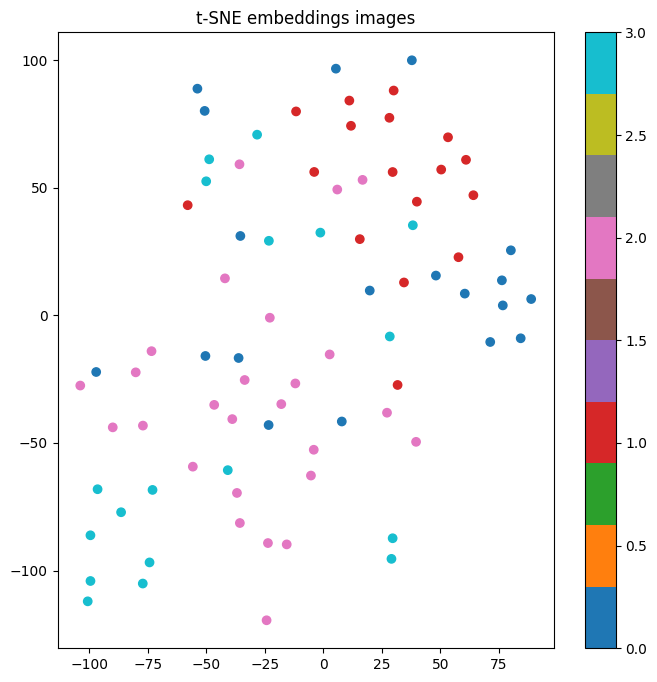

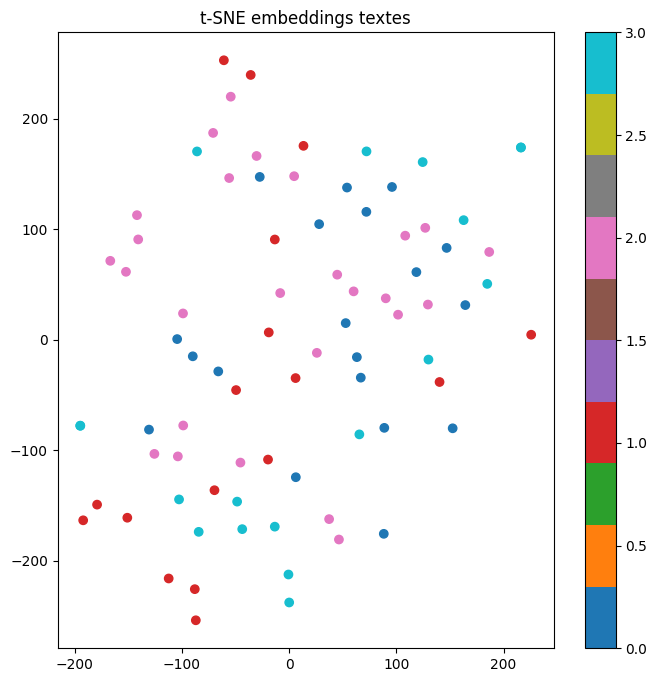

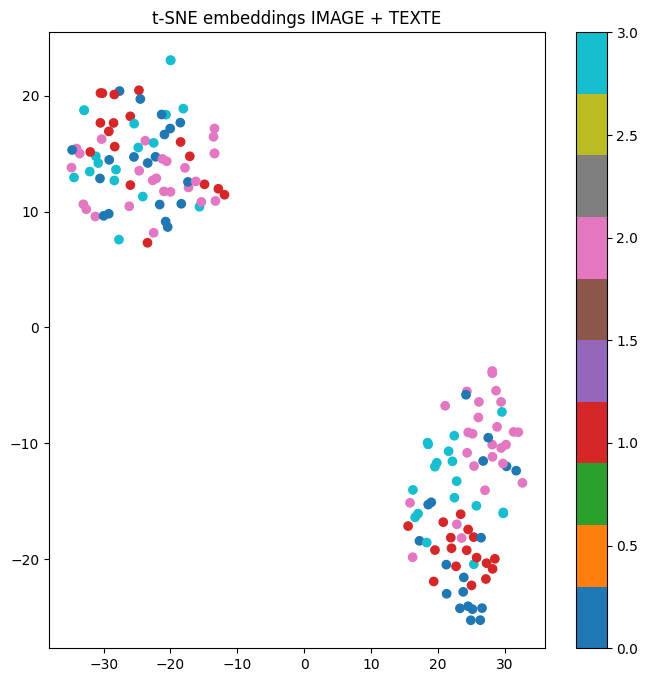

In [385]:

model_clip = SmallCLIP(
    VisionEncoder(),
    TextEncoder(max_seq_len, vocab_size, 128, num_heads=4, ff_dim=256, num_layers=2)
)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip.to(device)
img_emb, txt_emb, labels = get_embeddings(model_clip, val_loader, device)
tsne_img_emb(img_emb, labels)
tsne_txt_emb(txt_emb, labels)
tsne_combined(img_emb, txt_emb, labels)


In [386]:
def evaluate_clip(model, loader, device):
    model.eval()
    total_loss = 0
    n = 0

    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)

            logits, img_emb, txt_emb = model(images, input_ids)
            loss = clip_loss(logits)

            total_loss += loss.item() * images.size(0)
            n += images.size(0)

    return total_loss / n


In [395]:
from tqdm import tqdm

epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"

embed_dim = 128
best_test_loss = float("inf")
patience = 5
wait = 0
best_state = None


vision_encoder = VisionEncoder(embed_dim=embed_dim)
text_encoder   = TextEncoder(max_seq_len, vocab_size, embed_dim=embed_dim)

model_clip = SmallCLIP(vision_encoder, text_encoder, init_temperature=0.07)
model_clip.to(device)

optimizer = torch.optim.Adam(model_clip.parameters(), lr=1e-4)
train_losses = []
test_losses = []
for epoch in range(epochs):
    model_clip.train()
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train")

    total_train_loss = 0
    n_train = 0

    for batch in train_bar:
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)

        logits, img_emb, txt_emb = model_clip(images, input_ids)
        loss = clip_loss(logits)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * images.size(0)
        n_train += images.size(0)

        train_bar.set_postfix(loss=loss.item())

    train_loss = total_train_loss / n_train
    train_losses.append(train_loss)
    test_loss = -1
    test_loss = evaluate_clip(model_clip, val_loader, device)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {test_loss:.4f}")

    if test_loss < best_test_loss:
        print(f"→ Validation loss improved: {best_test_loss:.4f} → {test_loss:.4f}")
        best_test_loss = test_loss
        best_state = model_clip.state_dict()  # save best model
        wait = 0
    else:
        wait += 1
        print(f"No improvement. Wait {wait}/{patience}")

        if wait >= patience:
            print("\nEarly stopping triggered!")
            break



Epoch 1/20 - Train: 100%|██████████| 78/78 [00:08<00:00,  9.39it/s, loss=1.41]


Epoch 1/20 | Train Loss: 2.2215 | Val Loss: 1.3873
→ Validation loss improved: inf → 1.3873


Epoch 2/20 - Train: 100%|██████████| 78/78 [00:08<00:00,  9.52it/s, loss=0.233] 


Epoch 2/20 | Train Loss: 0.3255 | Val Loss: 0.8775
→ Validation loss improved: 1.3873 → 0.8775


Epoch 3/20 - Train: 100%|██████████| 78/78 [00:08<00:00,  9.48it/s, loss=0.05]  


Epoch 3/20 | Train Loss: 0.0788 | Val Loss: 0.8209
→ Validation loss improved: 0.8775 → 0.8209


Epoch 4/20 - Train: 100%|██████████| 78/78 [00:08<00:00,  9.47it/s, loss=0.0165]


Epoch 4/20 | Train Loss: 0.0480 | Val Loss: 0.7198
→ Validation loss improved: 0.8209 → 0.7198


Epoch 5/20 - Train: 100%|██████████| 78/78 [00:08<00:00,  9.53it/s, loss=0.0131] 


Epoch 5/20 | Train Loss: 0.0370 | Val Loss: 0.7879
No improvement. Wait 1/5


Epoch 6/20 - Train: 100%|██████████| 78/78 [00:08<00:00,  9.56it/s, loss=0.0207] 


Epoch 6/20 | Train Loss: 0.0290 | Val Loss: 0.7073
→ Validation loss improved: 0.7198 → 0.7073


Epoch 7/20 - Train: 100%|██████████| 78/78 [00:08<00:00,  9.52it/s, loss=0.0182] 


Epoch 7/20 | Train Loss: 0.0213 | Val Loss: 0.7409
No improvement. Wait 1/5


Epoch 8/20 - Train: 100%|██████████| 78/78 [00:08<00:00,  9.47it/s, loss=0.0978] 


Epoch 8/20 | Train Loss: 0.0201 | Val Loss: 0.7322
No improvement. Wait 2/5


Epoch 9/20 - Train: 100%|██████████| 78/78 [00:08<00:00,  9.51it/s, loss=0.0917] 


Epoch 9/20 | Train Loss: 0.0196 | Val Loss: 0.6442
→ Validation loss improved: 0.7073 → 0.6442


Epoch 10/20 - Train: 100%|██████████| 78/78 [00:08<00:00,  9.49it/s, loss=0.00758]


Epoch 10/20 | Train Loss: 0.0218 | Val Loss: 0.6675
No improvement. Wait 1/5


Epoch 11/20 - Train: 100%|██████████| 78/78 [00:08<00:00,  9.47it/s, loss=0.00703]


Epoch 11/20 | Train Loss: 0.0267 | Val Loss: 0.7510
No improvement. Wait 2/5


Epoch 12/20 - Train: 100%|██████████| 78/78 [00:08<00:00,  9.53it/s, loss=0.00575]


Epoch 12/20 | Train Loss: 0.0250 | Val Loss: 0.7374
No improvement. Wait 3/5


Epoch 13/20 - Train: 100%|██████████| 78/78 [00:08<00:00,  9.53it/s, loss=0.00717]


Epoch 13/20 | Train Loss: 0.0184 | Val Loss: 0.6655
No improvement. Wait 4/5


Epoch 14/20 - Train: 100%|██████████| 78/78 [00:08<00:00,  9.54it/s, loss=0.00261]


Epoch 14/20 | Train Loss: 0.0207 | Val Loss: 0.6997
No improvement. Wait 5/5

Early stopping triggered!


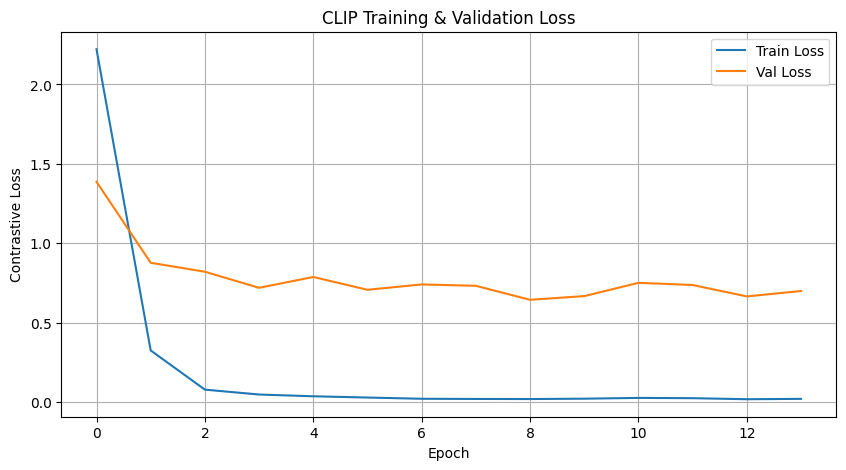

In [396]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Contrastive Loss")
plt.title("CLIP Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


{'caption': ['A man in a beret rides a bicycle down the street .', 'a brown dog running down a paved pathway', 'A biker patiently waits as his friend bikes ahead of him .', 'A man uses ice picks and crampons to scale ice .', 'A little boy kicks a soccer ball in the park .', 'A brown , black , and tan dog run in the ocean .', 'A big hound dog walking on a log in the woods .', 'A brown dog playing with a tennis ball', 'A grey and white dog is biting the ear of a white and brown dog .', 'A dog in midair cathing the red ball .', 'A basketball player in a duke uniform looks up .', 'Three dogs looking at a cement ledge .', 'a long bicyclist wearing a white helmet riding down a mountain path', 'A small girl spins in the waves in the bright sun .', 'A motocross rider is on a dirt hill .', 'The two dogs are in the water retrieving a stick .'], 'index': tensor([69, 32, 71, 52, 40, 80, 41, 74, 53, 45, 28, 11, 30, 66, 33, 14]), 'image': tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179,

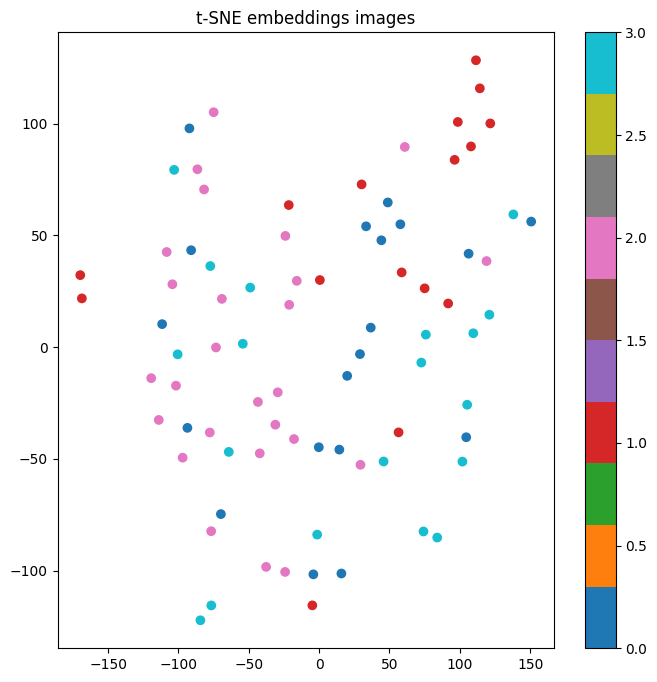

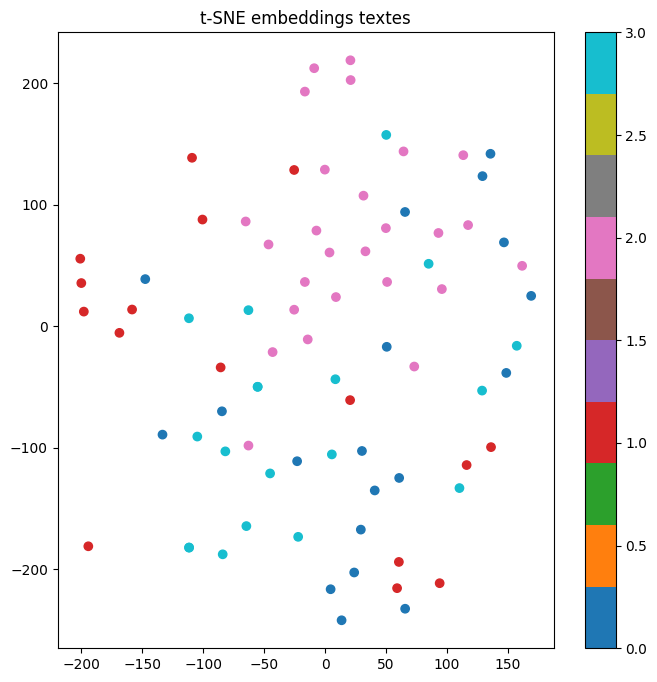

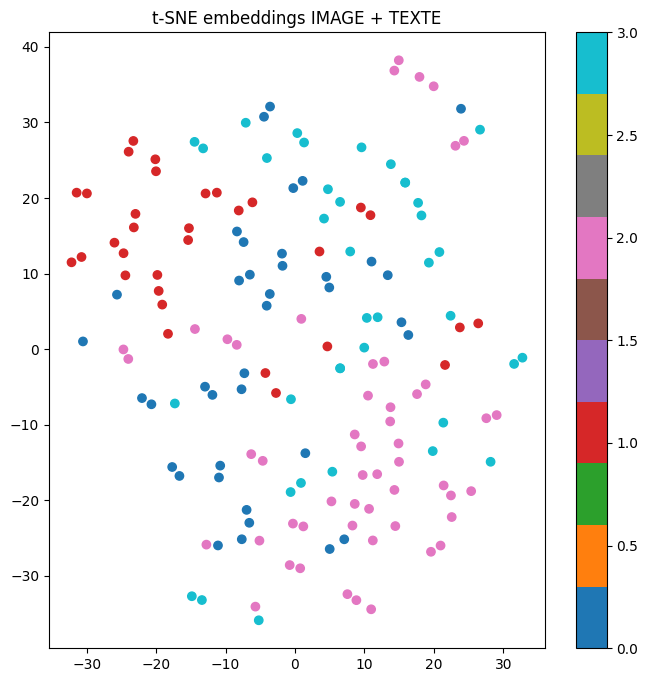

In [397]:
for batch in val_loader:
    print(batch)
img_emb, txt_emb, labels = get_embeddings(model_clip, val_loader, device)
tsne_img_emb(img_emb, labels)
tsne_txt_emb(txt_emb, labels)
tsne_combined(img_emb, txt_emb, labels)

In [398]:
def retrieval_accuracy(model, dataloader, device):
    model.eval()
    all_img_emb = []
    all_txt_emb = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)

            _, img_emb, txt_emb = model(images, input_ids)
            img_emb = F.normalize(img_emb, dim=-1)
            txt_emb = F.normalize(txt_emb, dim=-1)

            all_img_emb.append(img_emb.cpu())
            all_txt_emb.append(txt_emb.cpu())

    img_emb = torch.cat(all_img_emb)   # [N, D]
    txt_emb = torch.cat(all_txt_emb)   # [N, D]

    sims = img_emb @ txt_emb.T         # [N, N]
    preds = sims.argmax(dim=1)

    labels = torch.arange(len(img_emb))

    acc = (preds == labels).float().mean().item()
    return acc


In [399]:
print(retrieval_accuracy(model_clip, train_loader, device))
print(retrieval_accuracy(model_clip, test_loader, device))
# print(retrieval_accuracy(model_clip, val_loader, device))


0.4663461446762085
0.5825892686843872


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.64].


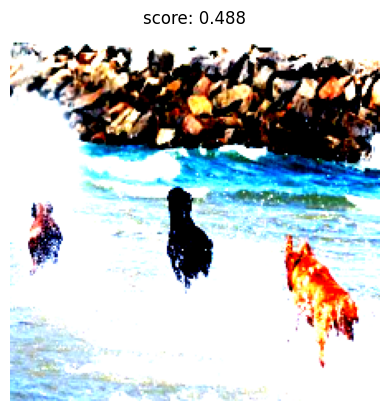

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


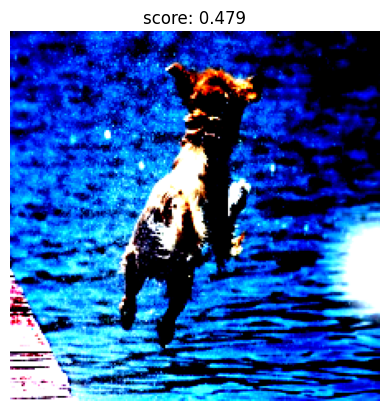

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


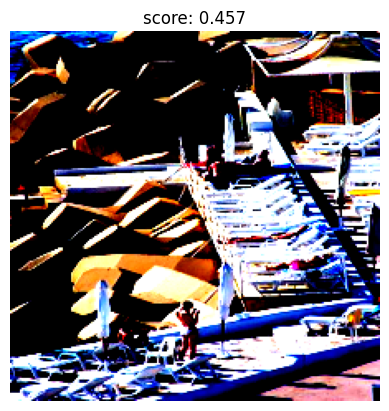

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


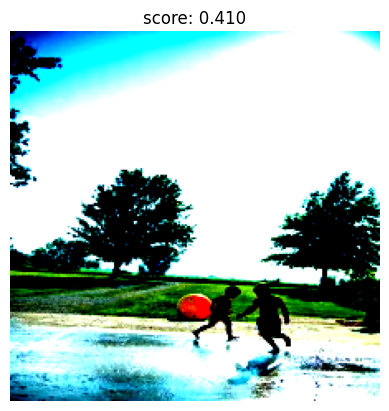

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..2.64].


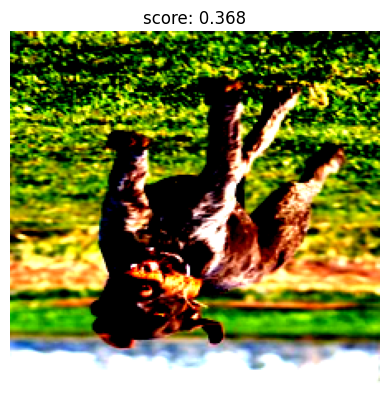

In [400]:
def compute_image_embeddings(model, dataloader, device):
    model.eval()
    all_img_embs = []
    all_images    = []   # <-- Ici on met les images une par une
    all_indices   = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(device)         # [B, 3, 224, 224]
            indices = batch["index"]                   # [B]

            # Embedding des images SEULES
            img_emb = model.vision(images)             # [B, D]
            img_emb = F.normalize(img_emb, dim=-1)

            # Stockage embeddings
            all_img_embs.append(img_emb.cpu())

            # Stockage images UNE PAR UNE
            for img in batch["image"]:                # img : [3,224,224]
                all_images.append(img)                # on stocke l’image brute

            all_indices.extend(indices.tolist())

    # Concat embeddings seulement (images = liste)
    all_img_embs = torch.cat(all_img_embs, dim=0)       # [N, D]

    return all_img_embs, all_images, all_indices


def text_to_topk_images(model, text, tokenizer, max_seq_len, all_img_embs,
                        all_img_paths, k=5, device="cuda"):
    model.eval()

    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_seq_len, padding="post")
    txt_ids = torch.tensor(padded).to(device)

    with torch.no_grad():
        _, txt_emb = None, model.text(txt_ids)
        txt_emb = F.normalize(txt_emb[0], dim=-1)

        img_embs = F.normalize(all_img_embs.to(device), dim=-1)
        sims = img_embs @ txt_emb

        topk_vals, topk_idx = sims.topk(k)
        topk_paths = [all_img_paths[i] for i in topk_idx.cpu().tolist()]

    return topk_paths, topk_vals.cpu()


all_img_embs, all_img_paths, all_indices= compute_image_embeddings(model_clip, test_loader, device)
top_paths, top_vals = text_to_topk_images(model_clip, "The kid is swimming in the water", tokenizer, max_seq_len, all_img_embs, all_img_paths)
for img_tensor, score in zip(top_paths, top_vals):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    plt.title(f"score: {score:.3f}")
    plt.axis("off")
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831376].


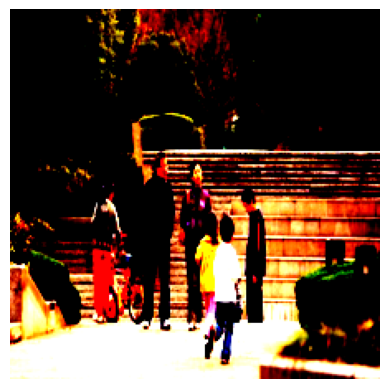

(['A boy is jumping on an inflatable ring and a girl is watching him',
  'A couple ride bikes next to an orange fence by the ocean .',
  'A girl in a bikini and sneakers makes her way out of the water and onto the rocks .',
  'A biker patiently waits as his friend bikes ahead of him .',
  'A football player is in action among other players .'],
 tensor([0.2596, 0.2519, 0.1738, 0.1731, 0.1382]))

In [401]:

def compute_text_embeddings(model, dataloader, device):
    model.eval()
    all_txt_embs = []
    all_captions = []

    with torch.no_grad():
        for batch in dataloader:
            # Captions brutes (strings)
            captions = batch["caption"]           # liste de length B
            input_ids = batch["input_ids"].to(device)  # [B, L]

            # Embeddings textuels SEULS (pas besoin d'images)
            txt_emb = model.text(input_ids)       # [B, D]
            txt_emb = F.normalize(txt_emb, dim=-1)

            # stockage
            all_txt_embs.append(txt_emb.cpu())
            all_captions.extend(captions)

    # concatène toutes les batches
    all_txt_embs = torch.cat(all_txt_embs, dim=0)     # [N, D]

    return all_txt_embs, all_captions



def image_to_topk_texts(model, image_tensor, all_txt_embs, all_captions,
                        k=5, device="cuda"):
    """
    image_tensor: [3,224,224] — image transformée
    all_txt_embs: [N, D]
    all_captions: liste de strings de longueur N
    """

    model.eval()

    with torch.no_grad():
        # 1. Embedding de l’image
        img = image_tensor.unsqueeze(0).to(device)  # → [1,3,224,224]
        img_emb = model.vision(img)[0]              # → [D]
        img_emb = F.normalize(img_emb, dim=-1)

        # 2. Normalisation embeddings texte
        txt_embs = F.normalize(all_txt_embs.to(device), dim=-1)

        # 3. Similarité image ↔ tous les textes
        sims = txt_embs @ img_emb                   # → [N]

        # 4. Top-k
        topk_vals, topk_idx = sims.topk(k)
        topk_vals = topk_vals.cpu()

        # 5. Récupérer les textes correspondants
        topk_texts = [all_captions[i] for i in topk_idx.cpu().tolist()]

    return topk_texts, topk_vals

img_tensor = test_dataset.__getitem__(0)["image"]  # récupère juste l'image
img = img_tensor.permute(1, 2, 0).cpu().numpy()
plt.imshow(img)
plt.axis("off")
plt.show()
all_txt_embs, all_captions = compute_text_embeddings(model_clip, val_loader, device)
image_to_topk_texts(model_clip, img_tensor, all_txt_embs, all_captions)